# Evaluate DeReC Fact-Checking Verifier

DRAGON has no explicit "grounded/ungrounded" labels, so we create a synthetic evaluation dataset:
- **Grounded**: answers via normal RAG pipeline (label=1) — all 600 questions
- **Ungrounded**: LLM answers WITHOUT context (label=0) — same 600 questions

Total: 1200 examples (600 grounded + 600 ungrounded).
Then run DeReC verifier and measure its ability to distinguish grounded from ungrounded.

## 1. Setup

In [2]:
!git clone -b feature/evaluate-fact-checking https://github.com/BigMak1/rag_fact_checking.git

Cloning into 'rag_fact_checking'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 50 (delta 9), reused 49 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 598.41 KiB | 5.81 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [5]:
!ls -al 

total 16
drwxr-xr-x 4 root root 4096 Feb 26 09:40 .
drwxr-xr-x 5 root root 4096 Feb 26 09:39 ..
drwxr-xr-x 5 root root 4096 Feb 26 09:40 rag_fact_checking
drwxr-xr-x 2 root root 4096 Feb 26 09:39 .virtual_documents


In [6]:
!pip install -q -r rag_fact_checking/DRAGON/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.3/508.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 7.7 MB/s eta 0:00:00
 

In [41]:
import json
import random
import os
from collections import defaultdict
import copy
import gc

os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"

from datasets import load_dataset, Dataset, DatasetDict
from langchain_community.llms import VLLM
from langchain_huggingface import HuggingFaceEmbeddings
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# from rag_bench import baseline, data, evaluator, results
from rag_fact_checking.DRAGON.rag_bench import baseline, data, evaluator, results

In [ ]:
# ── Constants ──
N_GROUNDED = 600
N_UNGROUNDED = 600

HIST_PRIVATE_QA_REPO_ID: str = "ai-forever/hist-rag-bench-private-qa"
HIST_PRIVATE_TEXTS_REPO_ID: str = "ai-forever/hist-rag-bench-private-texts"
RANDOM_SEED: int = 42
EMBEDDER_NAME: str = "ai-forever/FRIDA"
LLM_NAME: str = "bond005/meno-tiny-0.1"

DEREC_VERIFIER_REPO: str = "Makson4ic/derec-rawfc-deberta-frida"
HF_TOKEN: str = ""             # set if the verifier repo is private

# ── Prompts ──
LLM_PROMPT: str = """Проанализируйте заданный контекст и ответьте на вопрос пользователя на основе сведений, предоставленных в этом контексте.
Не давайте никаких объяснений и пояснений к своему ответу. Не пишите ничего лишнего. Не извиняйтесь, не стройте диалог. Выдавайте только ответ и ничего больше.
Отвечайте на русском языке.
Если в заданном контексте нет информации для ответа на вопрос пользователя, то ничего не придумывайте и просто откажитесь отвечать.
"""

LLM_PROMPT_NO_CONTEXT: str = """Ответьте на вопрос пользователя.
Не давайте никаких объяснений. Выдавайте только ответ и ничего больше.
Отвечайте на русском языке.
"""

# ── Helpers ──
def _build_question_index(questions_ds):
    """Map str(question_id) -> {"question": ...}"""
    idx = {}
    for item in questions_ds["train"]:
        idx[str(item["id"])] = {"question": item["question"]}
    return idx


def _build_text_index(texts_ds):
    """Map doc_id -> text content"""
    idx = {}
    for item in texts_ds["train"]:
        idx[item["id"]] = item["text"]
    return idx


def get_private_qa_dataset(version):
    return load_dataset(HIST_PRIVATE_QA_REPO_ID, revision=version)


def get_private_texts_dataset(version):
    return load_dataset(HIST_PRIVATE_TEXTS_REPO_ID, revision=version)


def get_public_to_private_texts_mapping(version):
    private_texts_ds = get_private_texts_dataset(version)
    mapping = {}
    for item in private_texts_ds["train"]:
        mapping[item["public_id"]] = item["id"]
    return mapping

In [9]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

## 2. Load Data & Models

In [10]:
texts_ds, questions_ds, version = data.get_datasets(is_hist=True)
print(f"version = {version}")

Latest texts version: 1.15.0
Latest questions version: 1.15.0


README.md:   0%|          | 0.00/374 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/793k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/542 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/377 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

Loaded texts dataset with 542 texts
Loaded questions dataset with 600 questions
version = 1.15.0


In [11]:
qa_dataset = get_private_qa_dataset(version)
mapping = get_public_to_private_texts_mapping(version)

README.md:   0%|          | 0.00/591 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/646k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/423 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/797k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/542 [00:00<?, ? examples/s]

In [ ]:
# Kaggle FIX
os.environ["LIBRARY_PATH"] = "/usr/local/nvidia/lib64:" + os.environ.get("LIBRARY_PATH", "")
print("LIBRARY_PATH =", os.environ["LIBRARY_PATH"])

llm = VLLM(
    model=LLM_NAME,
    tensor_parallel_size=2,
    max_new_tokens=256,
    top_p=0.95,
    temperature=0.3,
    vllm_kwargs={
        "gpu_memory_utilization": 0.45,
        "max_num_batched_tokens": 8192,
        "max_model_len": 4096,
        "disable_log_stats": True,
        "seed": RANDOM_SEED
    },
    disable_log_stats=True,
)
tok = AutoTokenizer.from_pretrained(LLM_NAME)

LIBRARY_PATH = /usr/local/nvidia/lib64:/usr/local/cuda/lib64/stubs


2026-02-26 09:46:23.581192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772099183.984147     102 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772099184.128630     102 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772099185.085490     102 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772099185.085535     102 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772099185.085538     102 computation_placer.cc:177] computation placer alr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

2026-02-26 09:47:13.185293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772099233.210578     279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772099233.218063     279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772099233.236000     279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772099233.236033     279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772099233.236037     279 computation_placer.cc:177] computation placer alr

(Worker_TP1 pid=305) ERROR 02-26 09:47:41 [fa_utils.py:104] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
(Worker_TP0 pid=304) ERROR 02-26 09:47:42 [fa_utils.py:104] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8


(Worker_TP0 pid=304) <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
(Worker_TP1 pid=305) <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
(Worker_TP1 pid=305) (Worker_TP0 pid=304) <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.nvrtc module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.nvrtc module instead.
<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.nvrtc module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.nvrtc module instead.
Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 10

In [13]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDER_NAME,
    model_kwargs={"trust_remote_code": True},
    encode_kwargs={"batch_size": 16, "prompt": "search_document: "},
    query_encode_kwargs={"prompt": "search_query: "}
)

retrieval = baseline.init_retriever(
    texts_ds,
    embedding_model,
    top_k=5,
    chunk_size=500,
    chunk_overlap=100,
)
generation = baseline.init_generation(retrieval, llm, tok, system_prompt=LLM_PROMPT)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Initializing retriever
> Creating vector store
> Vector store created for 542 documents
> Done for 124.71 seconds
Initializing generation chain
> Done


## 3. Grounded Answers (all 600 questions)

In [14]:
%%time
%%capture

res_grounded = baseline.get_results(
    generation, questions_ds, take=N_GROUNDED, write_logs=False
)
print(f"Grounded answers: {len(res_grounded)}")

CPU times: user 8.99 s, sys: 551 ms, total: 9.54 s
Wall time: 29.9 s


## 4. Ungrounded Answers (same 600 questions, no context)

For each question:
1. Run retriever to get documents (needed for DeReC evidence)
2. Generate answer with LLM **without context** — purely from parametric knowledge

In [ ]:
%%time
%%capture

# Build no-context prompt template
messages_no_ctx = [
    {"role": "system", "content": LLM_PROMPT_NO_CONTEXT},
    {"role": "user", "content": "Вопрос: {question}"},
]
template_no_ctx = tok.apply_chat_template(
    messages_no_ctx, tokenize=False, add_generation_prompt=True
)

res_ungrounded = {}
ungrounded_slice = questions_ds["train"].select(range(0, N_UNGROUNDED))

for item in tqdm(ungrounded_slice, desc="Ungrounded"):
    # Retrieve documents (for DeReC evidence later)
    try:
        docs = retrieval.invoke(item["question"])
    except AttributeError:
        docs = retrieval.get_relevant_documents(item["question"])

    # Generate answer WITHOUT context
    prompt = template_no_ctx.replace("{question}", item["question"])
    answer = llm.invoke(prompt)

    res_ungrounded[item["id"]] = {
        "found_ids": [d.metadata["id"] for d in docs],
        "model_answer": answer,
    }

In [17]:
print(f"Ungrounded answers: {len(res_ungrounded)}")

Ungrounded answers: 100


## 5. Combine Results + Labels

In [ ]:
# Keys in res_grounded and res_ungrounded now overlap (same 600 questions),
# so we can't merge into a single dict. Build separate label lists.
grounded_ids = set(res_grounded.keys())
ungrounded_ids = set(res_ungrounded.keys())

labels_grounded = {qid: True for qid in grounded_ids}
labels_ungrounded = {qid: False for qid in ungrounded_ids}

print(f"Grounded: {len(res_grounded)}, Ungrounded: {len(res_ungrounded)}")
print(f"Total examples: {len(res_grounded) + len(res_ungrounded)}")

In [ ]:
# Build self-contained fact-checking evaluation dataset
q_idx = _build_question_index(questions_ds)
t_idx = _build_text_index(texts_ds)

ref_answers = {}
for item in qa_dataset["train"]:
    ref_answers[item["public_id"]] = item["answer"]

dataset_records = []

# Grounded examples
for qid, pred in res_grounded.items():
    question = q_idx.get(str(qid), {}).get("question", "")
    found_ids = pred.get("found_ids", [])
    evidence_texts = [t_idx.get(doc_id, "") for doc_id in found_ids]
    dataset_records.append({
        "question_id": qid,
        "question": question,
        "reference_answer": ref_answers.get(qid, ""),
        "model_answer": pred["model_answer"],
        "found_ids": found_ids,
        "evidence_texts": evidence_texts,
        "is_grounded": True,
    })

# Ungrounded examples
for qid, pred in res_ungrounded.items():
    question = q_idx.get(str(qid), {}).get("question", "")
    found_ids = pred.get("found_ids", [])
    evidence_texts = [t_idx.get(doc_id, "") for doc_id in found_ids]
    dataset_records.append({
        "question_id": qid,
        "question": question,
        "reference_answer": ref_answers.get(qid, ""),
        "model_answer": pred["model_answer"],
        "found_ids": found_ids,
        "evidence_texts": evidence_texts,
        "is_grounded": False,
    })

results.save(dataset_records, "./fact_check_eval_dataset.json")
print(f"Saved fact-checking dataset: {len(dataset_records)} examples")
print(f"  Grounded: {sum(1 for r in dataset_records if r['is_grounded'])}")
print(f"  Ungrounded: {sum(1 for r in dataset_records if not r['is_grounded'])}")

## 5.1. Train/Val/Test Split for DeReC Fine-tuning

Split by `question_id` so that both grounded and ungrounded examples for the same question stay in the same split. 420/90/90 questions → 840/180/180 examples.

In [ ]:
# Train/val/test split by question_id
# Same question's grounded + ungrounded examples stay in the same split
unique_qids = list(set(r["question_id"] for r in dataset_records))
random.shuffle(unique_qids)

train_qids = set(unique_qids[:420])
val_qids = set(unique_qids[420:510])
test_qids = set(unique_qids[510:])

train_records = [r for r in dataset_records if r["question_id"] in train_qids]
val_records = [r for r in dataset_records if r["question_id"] in val_qids]
test_records = [r for r in dataset_records if r["question_id"] in test_qids]

print(f"Train: {len(train_records)} examples ({len(train_qids)} questions)")
print(f"Val:   {len(val_records)} examples ({len(val_qids)} questions)")
print(f"Test:  {len(test_records)} examples ({len(test_qids)} questions)")
print(f"Total: {len(train_records) + len(val_records) + len(test_records)}")

In [ ]:
# Save splits for DeReC fine-tuning
import os as _os

save_dir = "rag_fact_checking/DEREC/dataset/DRAGON"
_os.makedirs(save_dir, exist_ok=True)

results.save(train_records, f"{save_dir}/train.json")
results.save(val_records, f"{save_dir}/val.json")
results.save(test_records, f"{save_dir}/test.json")

print(f"Saved to {save_dir}/")
print(f"  train.json: {len(train_records)} examples")
print(f"  val.json:   {len(val_records)} examples")
print(f"  test.json:  {len(test_records)} examples")

## 6. DRAGON Metrics by Group

In [27]:
grounded_ids = set(res_grounded.keys())
ungrounded_ids = set(res_ungrounded.keys())

# Filter private qa_dataset to the relevant public_ids for each group
qa_grounded = qa_dataset["train"].filter(lambda x: x["public_id"] in grounded_ids)
qa_ungrounded = qa_dataset["train"].filter(lambda x: x["public_id"] in ungrounded_ids)
qa_grounded_dd = DatasetDict({"train": qa_grounded})
qa_ungrounded_dd = DatasetDict({"train": qa_ungrounded})

print(f"=== GROUNDED (n={len(qa_grounded)}) ===")
eval_grounded = evaluator.evaluate_rag_results(res_grounded, qa_grounded_dd, mapping)
_ = eval_grounded.to_table(overall_only=True)

print(f"\n=== UNGROUNDED (n={len(qa_ungrounded)}) ===")
eval_ungrounded = evaluator.evaluate_rag_results(res_ungrounded, qa_ungrounded_dd, mapping)
_ = eval_ungrounded.to_table(overall_only=True)

Filter:   0%|          | 0/600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/600 [00:00<?, ? examples/s]

=== GROUNDED (n=100) ===
Retrieval Metrics:
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Hit Rate |  0.8067 |
+----------+---------+
| MRR      |  0.7887 |
+----------+---------+

Generation Metrics:
+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| ROUGE-1         |  0.4978 |
+-----------------+---------+
| ROUGE-2         |  0.3341 |
+-----------------+---------+
| ROUGE-L         |  0.4819 |
+-----------------+---------+
| Exact Match     |  0.1200 |
+-----------------+---------+
| Substring Match |  0.1600 |
+-----------------+---------+

=== UNGROUNDED (n=100) ===
Retrieval Metrics:
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Hit Rate |  0.8400 |
+----------+---------+
| MRR      |  0.8358 |
+----------+---------+

Generation Metrics:
+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| ROUGE-1         |  0.0486 |
+-----------------+---------+
| ROU

## 7. DeReC Scoring

In [ ]:
# Free GPU memory from LLM before loading verifier
del llm

for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj

gc.collect()
torch.cuda.empty_cache()
print("LLM removed, GPU memory freed.")

In [ ]:
assert DEREC_VERIFIER_REPO.strip(), "Set DEREC_VERIFIER_REPO in the constants cell first!"

hf_token = HF_TOKEN.strip() or None
verifier_tok = AutoTokenizer.from_pretrained(DEREC_VERIFIER_REPO, token=hf_token)
verifier = AutoModelForSequenceClassification.from_pretrained(DEREC_VERIFIER_REPO, token=hf_token)
verifier.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
verifier.to(device)

num_labels = verifier.config.num_labels
print(f"Verifier: {DEREC_VERIFIER_REPO}, num_labels={num_labels}")

q_idx = _build_question_index(questions_ds)
t_idx = _build_text_index(texts_ds)

def _score_predictions(preds_dict, desc="scoring"):
    """Score a dict of {qid: {found_ids, model_answer}} with the verifier."""
    scores = {}
    with torch.no_grad():
        for qid, pred in tqdm(preds_dict.items(), desc=desc):
            question = q_idx.get(str(qid), {}).get("question", "")
            answer = pred.get("model_answer", "")
            found_ids = pred.get("found_ids", [])
            evidence = "\n".join([t_idx.get(doc_id, "") for doc_id in found_ids])[:4000]

            text = f"claim: question: {question}\nanswer: {answer} [SEP] evidence: {evidence}"
            inp = verifier_tok(
                text, max_length=512, padding="max_length",
                truncation=True, return_tensors="pt"
            )
            inp = {k: v.to(device) for k, v in inp.items()}
            probs = torch.softmax(verifier(**inp).logits, dim=-1)[0].cpu().numpy()

            if num_labels == 2:
                true_score = float(probs[1])  # grounded class
            else:
                true_score = float(probs[2] if probs.shape[0] >= 3 else probs.max())
            scores[qid] = true_score
    return scores

# Score grounded and ungrounded separately (keys overlap)
scores_grounded_dict = _score_predictions(res_grounded, "Grounded scoring")
scores_ungrounded_dict = _score_predictions(res_ungrounded, "Ungrounded scoring")

scores_grounded = list(scores_grounded_dict.values())
scores_ungrounded = list(scores_ungrounded_dict.values())

print(f"\nGrounded   — mean: {np.mean(scores_grounded):.4f}, median: {np.median(scores_grounded):.4f}, std: {np.std(scores_grounded):.4f}")
print(f"Ungrounded — mean: {np.mean(scores_ungrounded):.4f}, median: {np.median(scores_ungrounded):.4f}, std: {np.std(scores_ungrounded):.4f}")

## 8. Classification Metrics

In [ ]:
# Build aligned arrays: grounded (label=1) + ungrounded (label=0)
y_true = np.array([1] * len(scores_grounded) + [0] * len(scores_ungrounded))
y_scores = np.array(scores_grounded + scores_ungrounded)

# ROC-AUC
auc = roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Optimal threshold (Youden's J)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
best_tpr = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"ROC-AUC: {auc:.4f}")
print(f"Optimal threshold (Youden's J): {best_threshold:.4f}")
print(f"  TPR: {best_tpr:.4f}, FPR: {best_fpr:.4f}")

# Metrics at several thresholds
print("\n" + "="*65)
print(f"{'Threshold':>10} {'TPR':>8} {'FPR':>8} {'Precision':>10} {'F1':>8}")
print("="*65)
for t in [0.3, 0.4, 0.5, best_threshold, 0.6, 0.7, 0.8]:
    y_pred = (y_scores >= t).astype(int)
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tpr_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_t = fp / (fp + (y_true == 0).sum()) if (y_true == 0).sum() > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * prec * tpr_t / (prec + tpr_t) if (prec + tpr_t) > 0 else 0
    marker = " *" if abs(t - best_threshold) < 1e-6 else ""
    print(f"{t:>10.4f} {tpr_t:>8.4f} {fpr_t:>8.4f} {prec:>10.4f} {f1:>8.4f}{marker}")
print("="*65)
print("* = optimal (Youden's J)")

## 9. Visualizations

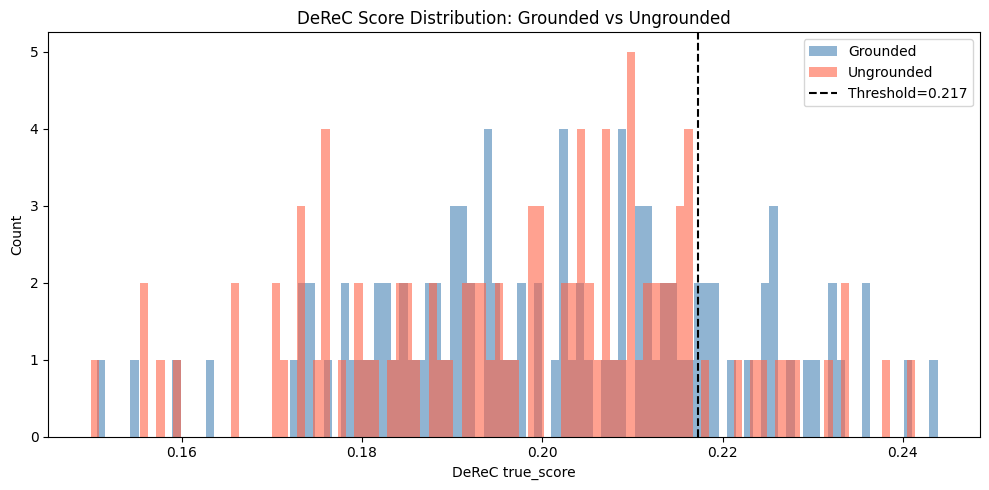

In [48]:
# Histogram: DeReC score distribution for grounded vs ungrounded
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(scores_grounded, bins=100, alpha=0.6, label="Grounded", color="steelblue")
ax.hist(scores_ungrounded, bins=100, alpha=0.6, label="Ungrounded", color="tomato")
ax.axvline(best_threshold, color="black", linestyle="--", label=f"Threshold={best_threshold:.3f}")
ax.set_xlabel("DeReC true_score")
ax.set_ylabel("Count")
ax.set_title("DeReC Score Distribution: Grounded vs Ungrounded")
ax.legend()
plt.tight_layout()
plt.show()

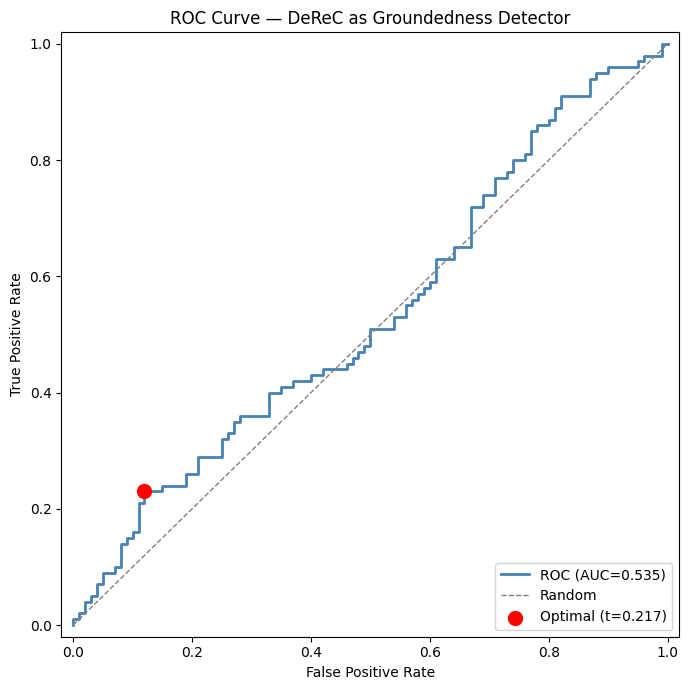

In [49]:
# ROC Curve
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(fpr, tpr, color="steelblue", lw=2, label=f"ROC (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random")
ax.scatter([best_fpr], [best_tpr], color="red", s=100, zorder=5,
           label=f"Optimal (t={best_threshold:.3f})")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — DeReC as Groundedness Detector")
ax.legend(loc="lower right")
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Scatter: ROUGE-L vs DeReC score for ungrounded answers
# Shows parametric knowledge cases: high ROUGE-L + should be low DeReC
rouge_l_ungrounded = []
derec_ungrounded = []

for qid in ungrounded_ids:
    public_id_str = str(qid)
    if public_id_str in eval_ungrounded.individual_results:
        rouge_l = eval_ungrounded.individual_results[public_id_str]["generation"]["rougeL"]
    elif qid in eval_ungrounded.individual_results:
        rouge_l = eval_ungrounded.individual_results[qid]["generation"]["rougeL"]
    else:
        continue
    rouge_l_ungrounded.append(rouge_l)
    derec_ungrounded.append(scores_ungrounded_dict[qid])

fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(rouge_l_ungrounded, derec_ungrounded, alpha=0.6, c="tomato", edgecolors="gray", s=40)
ax.axhline(best_threshold, color="black", linestyle="--", alpha=0.7, label=f"DeReC threshold={best_threshold:.3f}")
ax.set_xlabel("ROUGE-L (ungrounded vs reference)")
ax.set_ylabel("DeReC true_score")
ax.set_title("Ungrounded: ROUGE-L vs DeReC Score\n(top-right = parametric knowledge)")
ax.legend()
plt.tight_layout()
plt.show()

# Count parametric knowledge cases
n_high_rouge = sum(1 for r in rouge_l_ungrounded if r > 0.5)
n_high_rouge_high_derec = sum(
    1 for r, d in zip(rouge_l_ungrounded, derec_ungrounded) if r > 0.5 and d > best_threshold
)
print(f"Ungrounded with ROUGE-L > 0.5 (parametric knowledge): {n_high_rouge}/{len(rouge_l_ungrounded)}")
print(f"  of which DeReC > threshold (false positives): {n_high_rouge_high_derec}")